# Introduction

This notebook studies a number of data sets on COVID-19 in Canada, published by Health Canada. The intention
is to reveal insights into vaccine distribution and circulating variants, specifically within the province of Newfoundland and Labrador. It will also demonstrate the effectiveness of a "hybrid" modelling approach for describing and predicting the progression of the disease within the province.

# Modelling Approach

The approach to modelling COVID-19 in Newfoundland and Labrador will involve mutiple tools and models, all with the intention of increasing the accuracy of predictions. The models and tools used are as follows:

## Facebook Prophet

Facebook Prophet is a forecasting tool which is useful for modelling time series data, particularly when there are strong seasonal effects and missing data. It is quite useful for forecasting data that exhibits trends and seasonal patterns. Prophet is used in this case to train the model on the dataset containing dates and the total cases of COVID-19 in Newfoundland and Labrador. After training, predictions are made for both historical data and a 365-day future forecast. The historical predictions from Prophet are used to computer the compined forecast with other models.

## Random Forest Regressor

Random Forest is an ensemble machine learning algorithm that is used for both classification and regression tasks. It works by creating multiple decision trees and outputting the average prediction from all trees. The Random Forest model in this case is trained using teh number of days (since the start data) as a feature, with the total number of cases as the target. Predictions are made for both the historical data and 365 days into the future. These predictions are used for combining with Prophet's predictions.

## ElasticNet

ElasticNet is a linear regression model that combinees both L1 and L2 regularization. It is used to improve the performance of linear models, particularly when the dataset has a large number of correlated features. In this case, the predictions from both the Prophet and Random Forest models (for historical data) are combined into a new feature matrix. This combined prediction serves as input to the ElasticNet model. ElasticNet is used to fit the combined predictions and predict the total cases in the historical period. The future predictions are also combined and fed into the model, in order to obtain the combined forecast for the next 365 days.

In short, the modelling process may be summarized as follows:

- Prophet: Captures the seasonality and trends in the time series data (COVID-19 cases) to provide initial predictions.
- Random Forest: Models the relationship between the number of days since the start of the dataset and the total COVID-19 cases. It captures the non-linear relationship between the time variable and cases.
- ElasticNet: Combines the predictions from Prophet and Random Forest to produce a more robust final prediction. ElasticNet helps regularize the linear relationship between the two model outputs and the actual total cases.

The aim is to leverage both the temporal trend-capturing capability of Prophet, the flexibility of Random Forest to capture complex relationships and the regularization provided by ElasticNet for generalizable, stable predictions.

## Plots

00:49:04 - cmdstanpy - INFO - Chain [1] start processing
00:49:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/Caskroom/miniconda/base/envs/jupyterlab/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/jupyterlab/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+07, tolerance: 1.531e+07
  model = cd_fast.enet_coordinate_descent(
00:49:04 - cmdstanpy - INFO - Chain [1] start processing
00:49:04 - cmdstanpy - INFO - Chain [1] done processing
00:49:04 - cmdstanpy - INFO - Chain [1] start processing
00:49:05 - cmdstanpy - INFO - Chain [1] done processing
00:49:05 - cmdstanpy - INFO -

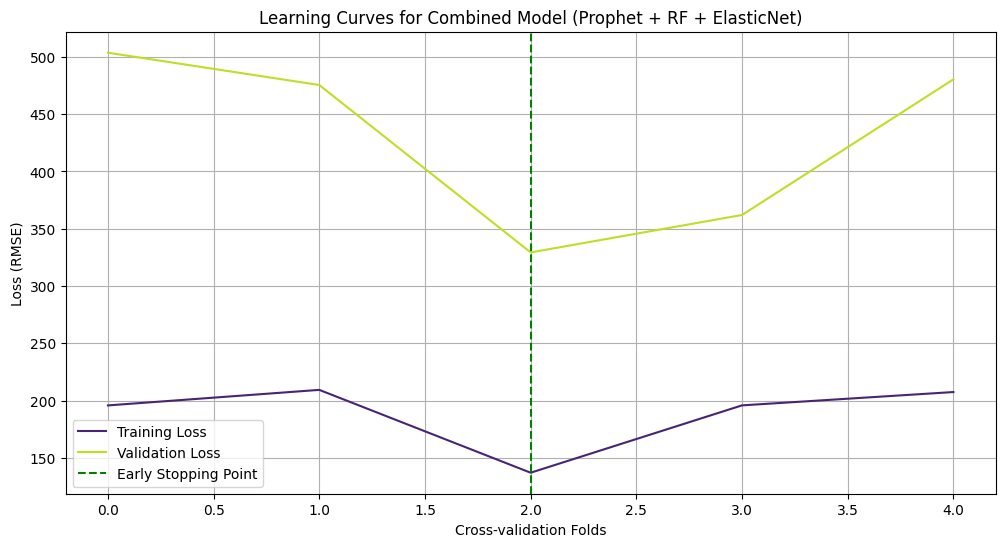

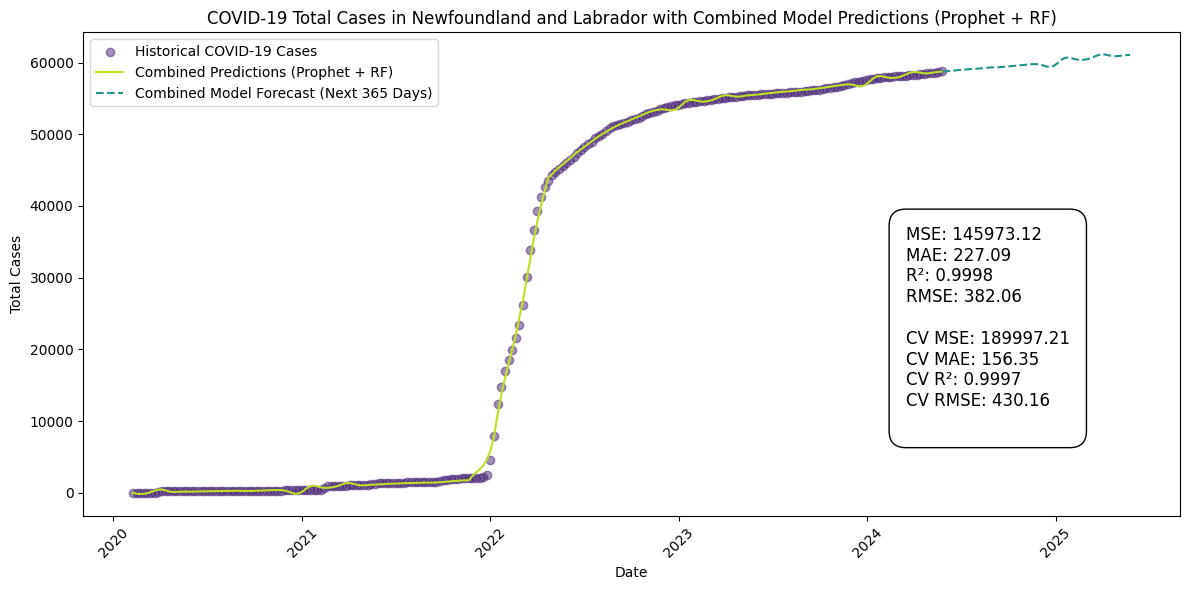

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from datetime import timedelta

# Load dataset
df = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv")

# Filter data for Newfoundland and Labrador and preprocess
df = df[df['prname'] == "Newfoundland and Labrador"]

# Convert 'date' to datetime and handle errors (invalid dates will be NaT)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid or missing dates
df = df.dropna(subset=['date'])

# Sort the data by date
df = df.sort_values('date')

# Ensure 'totalcases' is numeric and drop any rows with missing values
df['totalcases'] = pd.to_numeric(df['totalcases'], errors='coerce')
df = df.dropna(subset=['totalcases'])

# Prepare the data for Facebook Prophet
df_prophet = df[['date', 'totalcases']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'totalcases': 'y'})

# Prepare the data for Random Forest (use days since the start of the data)
df['days'] = (df['date'] - df['date'].min()).dt.days  # Convert dates to number of days
X_rf = df[['days']]  # Features for Random Forest (days)
y_rf = df['totalcases']  # Target for Random Forest

# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Make predictions with Prophet for the entire dataset (historical + future)
future = prophet_model.make_future_dataframe(periods=365)  # Generate future dates (next 365 days)
forecast_prophet = prophet_model.predict(future)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_rf, y_rf)

# Predict with Random Forest for the entire dataset (historical + future)
X_rf_future = np.arange(df['days'].max() + 1, df['days'].max() + 366).reshape(-1, 1)  # Predict the next 365 days
rf_predictions_future = rf_model.predict(X_rf_future)

# Get historical Prophet and RF predictions
historical_prophet_predictions = forecast_prophet['yhat'][:len(df)].values  # Prophet predictions for historical data
rf_predictions_historical = rf_model.predict(X_rf)  # Random Forest predictions for historical data

# Combine historical predictions (Prophet + RF) for the historical period using ElasticNet
X_meta = np.column_stack((historical_prophet_predictions, rf_predictions_historical))  # Features for meta-model
meta_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # ElasticNet with regularization
meta_model.fit(X_meta, df['totalcases'])

# Get combined predictions from the meta-model (ElasticNet combining Prophet and RF)
combined_predictions_historical = meta_model.predict(X_meta)

# Combine future predictions (Prophet + RF) for the next 365 days using ElasticNet
X_meta_future = np.column_stack((forecast_prophet['yhat'][-365:].values, rf_predictions_future))
combined_predictions_future = meta_model.predict(X_meta_future)

# Perform cross-validation (5-fold) for combined model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mse_list = []
cv_mae_list = []
cv_r2_list = []
cv_rmse_list = []

# To store training and validation losses
train_losses = []
val_losses = []

for train_index, val_index in kf.split(df):
    # Extract training and validation data based on indices
    train_data = df.iloc[train_index]
    val_data = df.iloc[val_index]
    
    # Prepare data for Prophet
    df_prophet_train = train_data[['date', 'totalcases']].rename(columns={'date': 'ds', 'totalcases': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(df_prophet_train)
    forecast_prophet_train = prophet_model.predict(df_prophet_train[['ds']])
    historical_prophet_predictions = forecast_prophet_train['yhat'].values

    # Prepare data for Random Forest
    X_rf_train = train_data[['days']]
    y_rf_train = train_data['totalcases']
    rf_model = RandomForestRegressor(n_estimators=100)
    rf_model.fit(X_rf_train, y_rf_train)
    rf_predictions_historical = rf_model.predict(X_rf_train)

    # Combine the historical predictions (Prophet + RF)
    X_meta_train = np.column_stack((historical_prophet_predictions, rf_predictions_historical))
    meta_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # ElasticNet with regularization
    meta_model.fit(X_meta_train, train_data['totalcases'])

    # Predictions on the validation set
    val_prophet_data = val_data[['date']].rename(columns={'date': 'ds'})
    historical_prophet_predictions_val = prophet_model.predict(val_prophet_data)['yhat'].values
    rf_predictions_val = rf_model.predict(val_data[['days']])

    X_meta_val = np.column_stack((historical_prophet_predictions_val, rf_predictions_val))
    combined_predictions_val = meta_model.predict(X_meta_val)

    # Evaluate metrics on validation set
    mse = mean_squared_error(val_data['totalcases'], combined_predictions_val)
    mae = mean_absolute_error(val_data['totalcases'], combined_predictions_val)
    r2 = r2_score(val_data['totalcases'], combined_predictions_val)
    rmse = np.sqrt(mse)

    # Append the metrics to the lists
    cv_mse_list.append(mse)
    cv_mae_list.append(mae)
    cv_r2_list.append(r2)
    cv_rmse_list.append(rmse)

    # Calculate losses for learning curves
    train_loss = np.sqrt(mean_squared_error(train_data['totalcases'], meta_model.predict(X_meta_train)))
    val_loss = np.sqrt(mean_squared_error(val_data['totalcases'], combined_predictions_val))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Calculate the average cross-validation metrics
cv_mse = np.mean(cv_mse_list)
cv_mae = np.mean(cv_mae_list)
cv_r2 = np.mean(cv_r2_list)
cv_rmse = np.mean(cv_rmse_list)

# Plot the learning curves for the combined model (Prophet + RF + ElasticNet)
plt.figure(figsize=(12, 6))

plt.plot(train_losses, label='Training Loss', color=plt.cm.viridis(0.1))
plt.plot(val_losses, label='Validation Loss', color=plt.cm.viridis(0.9))

# Mark the early stopping point with a vertical line
early_stop_epoch = np.argmin(val_losses)
plt.axvline(x=early_stop_epoch, color='green', linestyle='--', label='Early Stopping Point')

# Adding labels and title
plt.title('Learning Curves for Combined Model (Prophet + RF + ElasticNet)')
plt.xlabel('Cross-validation Folds')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.grid(True)

plt.show()

# Plot the results
plt.figure(figsize=(12, 6))

# Plot historical data (actual cases)
plt.scatter(df['date'], df['totalcases'], label='Historical COVID-19 Cases', color=plt.cm.viridis(0.1), alpha=0.5)

# Plot combined predictions (using ElasticNet) for historical period
plt.plot(df['date'], combined_predictions_historical, label='Combined Predictions (Prophet + RF)', linestyle='-', color=plt.cm.viridis(0.9))

# Plot combined model predictions for the next 365 days as a dashed line
future_dates = future['ds'][-365:]
plt.plot(future_dates, combined_predictions_future, label='Combined Model Forecast (Next 365 Days)', linestyle='--', color=plt.cm.viridis(0.5))

# Formatting
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('COVID-19 Total Cases in Newfoundland and Labrador with Combined Model Predictions (Prophet + RF)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Add the text box inside the plot area
performance_metrics = (
    f'MSE: {mean_squared_error(df["totalcases"], combined_predictions_historical):.2f}\n'
    f'MAE: {mean_absolute_error(df["totalcases"], combined_predictions_historical):.2f}\n'
    f'R²: {r2_score(df["totalcases"], combined_predictions_historical):.4f}\n'
    f'RMSE: {np.sqrt(mean_squared_error(df["totalcases"], combined_predictions_historical)):.2f}\n\n'
    f'CV MSE: {cv_mse:.2f}\n'
    f'CV MAE: {cv_mae:.2f}\n'
    f'CV R²: {cv_r2:.4f}\n'
    f'CV RMSE: {cv_rmse:.2f}\n'
)

# Adjust the position of the text box inside the plot
plt.gca().text(0.75, 0.6, performance_metrics, transform=plt.gca().transAxes, fontsize=12,
              verticalalignment='top', horizontalalignment='left',
              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Show the plot
plt.show()


## Analysis

### Learning Curves Plot

This plot shows the learning curves for the combined model. The training loss, represented by a purple line, is consistently low across all the folds, staying relatively stable. This is an indication that the model is able to fit the training data well, criitically, without overfitting. The validation loss, represented by the green line, shows some fluctuation, starting at a relatively high value and decreasing after early stopping is triggered. The drop in validation loss around the second fold suggesets that the model is learning better from the validation set after a few iterations and that the overfitting is beginning to stabilize after early stopping. The vertical, green dashed line represents the point at which that early stopping was triggered; after this point, the validation loss does not improve significantly. This demonstrates that the model has effectively stopping learning at a point where further training might have resulted in overfitting.

# What are the most common variants of COVID-19 currently circulating within the province?

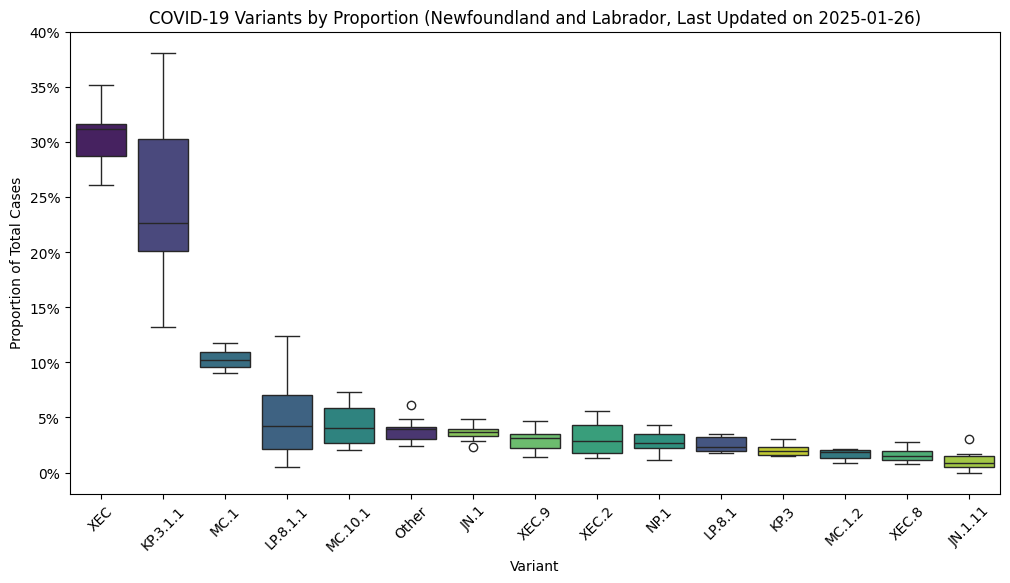

In [7]:
# Load the dataset.
variants_data = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-epiSummary-variants.csv")

# Ensure the 'week of collection' is converted to datetime.
variants_data['week of collection'] = pd.to_datetime(variants_data['week of collection'])

# Divide every values in proportions by 100.
variants_data['proportions'] = variants_data['proportions'] / 100

# Sort variants by median proportion in descending order.
variant_medians = variants_data.groupby('variant')['proportions'].median().sort_values(ascending=False)
ordered_variants = variant_medians.index

# Boxplot of variant vs proportion, sorted by median in descending order with Viridis color palette.
plt.figure(figsize=(12, 6))
sns.boxplot(x='variant', y='proportions', data=variants_data, order=ordered_variants, palette='viridis', hue="variant")

last_updated = max(variants_data['week of collection'])

# Set plot title and labels.
plt.title(f"COVID-19 Variants by Proportion (Newfoundland and Labrador, Last Updated on {last_updated.date()})")
plt.xlabel("Variant")
plt.ylabel("Proportion of Total Cases")

# Format y-axis to show percentages.
formatter = FuncFormatter(lambda x, _: f'{x*100:.0f}%')  # Convert to percentage
plt.gca().yaxis.set_major_formatter(formatter)

# Rotate the x-ticks for better readability.
plt.xticks(rotation=45)

plt.show()




There are at least **13** known strains of COVID-19 circulating within the province. Of these some variants have higher proportions, particularly XEC and KP.3.1.1, indicating that these variants represent a larger share of the total cases in the province. The other variants have much lower proportions, representing a smaller portion of total cases. Several variants clearly have outlier values, as shown by the points outside the whiskers of the box plots. The interquartile ranges (IQRs) for variants such as XEC and KP.3.1.1 are relatively wide, indicating signficant variation in the numbers of their cases over time. The medians of variants such as XEC and KP.3.1.1 appear to be the highest; for most cases, these variants are more prevalent. The differences in proportions suggest that the XEC and KP.3.1.1 strains dominate the total case count, whereas the others are less prevalent.

# How many vaccines have been distributed within the province?

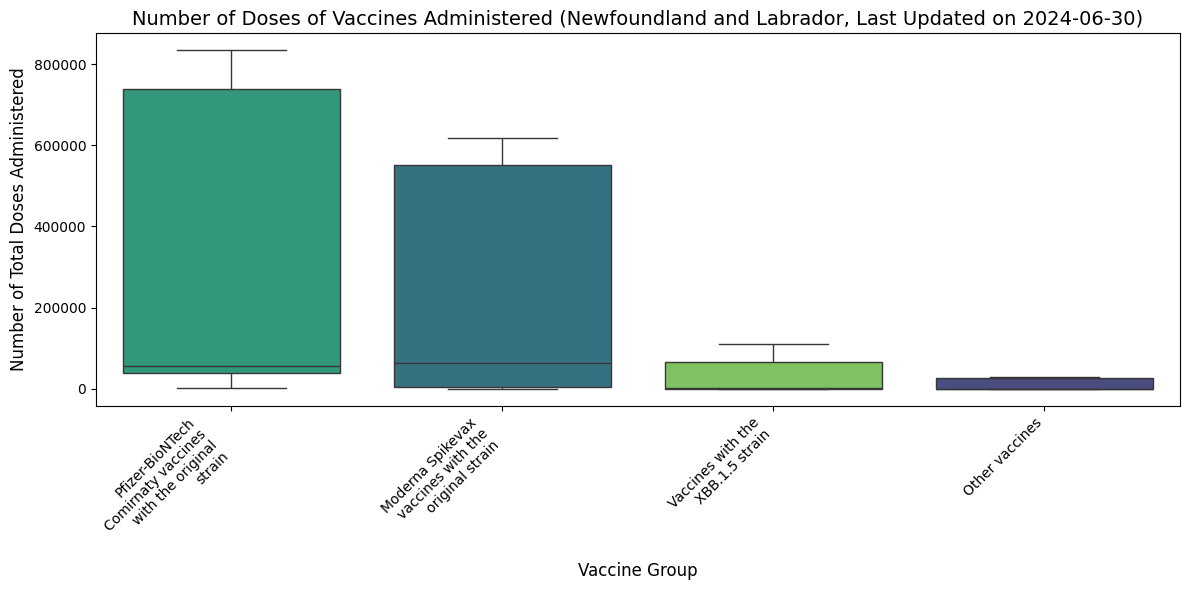

In [8]:
# Load the dataset.
vaccine_data = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/vaccination-administration-bydosenumber_grouped.csv")

# Filter the data for Newfoundland and Labrador.
vaccine_data = vaccine_data[vaccine_data['prename'] == "Newfoundland and Labrador"]

# Filter "Total" and "Unknown" so that they are not displayed.
vaccine_data = vaccine_data[(vaccine_data['vaccine_group'] != "Total") & (vaccine_data['vaccine_group'] != "Unknown")]

# Select the relevant columns.
vaccine_data = vaccine_data[['vaccine_group', 'numtotal_totaldoses_admin', 'week_end']]

# Exclude specific vaccine groups.
vaccine_data = vaccine_data[(vaccine_data['vaccine_group'] != "Moderna Spikevax formulations") & (vaccine_data['vaccine_group'] != "Pfizer-BioNTech Comirnaty formulations")]

# Convert 'week_end' to datetime and calculate the most recent date.
vaccine_data['week_end'] = pd.to_datetime(vaccine_data['week_end'])
last_updated = vaccine_data['week_end'].max().date()

# Compute the order of vaccine groups by descending maximum doses administered.
order = vaccine_data.groupby('vaccine_group')['numtotal_totaldoses_admin'].max().sort_values(ascending=False).index

# Plotting the boxplot for vaccine group vs number of doses administered.
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='vaccine_group',
    y='numtotal_totaldoses_admin',
    data=vaccine_data,
    order=order,  # Use the computed order based on maximum values.
    palette="viridis",
    hue="vaccine_group",
)

# Add title and labels.
plt.title(f"Number of Doses of Vaccines Administered (Newfoundland and Labrador, Last Updated on {last_updated})", fontsize=14)
plt.xlabel("Vaccine Group", fontsize=12)
plt.ylabel("Number of Total Doses Administered", fontsize=12)

# Wrap x-axis labels and rotate them for better readability.
labels = plt.gca().get_xticklabels()

# Set tick positions and labels explicitly
tick_positions = plt.gca().get_xticks()  # Get the current tick positions
wrapped_labels = [textwrap.fill(label.get_text(), width=20) for label in labels]

# Apply the wrapped labels to the ticks
plt.gca().set_xticks(tick_positions)  # Ensure the ticks are set
plt.gca().set_xticklabels(wrapped_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


The Pfizer-BioNTech Comirnaty vaccines with the original strain has the largest range of doses administered, with a significant number of doses falling in the 200,000 to 800,000 range. There is substantial variability in the data and high outliers, suggesting that there were some weeks in which exceptionally high numberes of doses were adminsitered. The Moderna Spikevax vaccines with the original strain has a slightly smaller distribution than Pfizer's but there is still significant variability. Vaccines with the XBB.1.5 strain have the smallest distribution, indicating fewer doses administered. The Pfizer-BioNTech vaccines with the original strain clearly has the largest number of doses administered, with the highest upper quartile. There are significant outliers in that group in particular, however, indicating that some weeks or months had notably higher numbers of doses administered than others. The Moderna vaccines with the original strain and formulations show more consistent administration over time.

# Conclusion

This notebook has illustrated the strength of combining the random forest regressor, SIR and XGBoost as a hybrid model for describing and predicting the spread of COVID-19, using real data from Newfoundland and Labrador, Canada. The model's predictive power and ability to provide concrete answers for policy makers give it a considerable advantage over other alternatives. This notebook has also explored some of the data sets available on COVID-19 in Canada, in order to provide insight into the vaccination effort, as well as the variants that currently circulate within the province. It remains to be seen what the final financial and social impacts of COVID-19 will be. It took nearly **1600 days** for the pandemic to reach a stage where it could be considered "over" and public health restrictions were finally lifted. During that time, many local businesses were forced to close their doors, unable to keep operating in such a restricted and uncertain environment. Modelling could potentially provide answers to the many questions that arise during a COVID-19 outbreak; how long will it last? What affects its spread the most? Are policies to contain its spread actually effective? All of these questions can be answered with modelling, but critically, the **right choice** of model must be made.